In [112]:
import wrangle_zillow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
df = wrangle_zillow.get_zillow_data()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,transactiondate
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0,2017-01-01
4,3.0,3.0,1312.0,119407.0,1964.0,1533.89,6037.0,2017-01-01


In [3]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [4]:
df['area'] = df.calculatedfinishedsquarefeet

In [5]:
df = df.drop(columns='calculatedfinishedsquarefeet')

In [6]:
df = df.dropna()

In [7]:
col_list = ['bedroomcnt', 'bathroomcnt', 'area', 'taxvaluedollarcnt', 'taxamount']

In [8]:
df = wrangle_zillow.remove_outliers(df, 1, col_list)

In [9]:
df.shape

(45644, 8)

In [10]:
df['bed'] = df.bedroomcnt
df['bath'] = df.bathroomcnt
df['taxvalue'] = df.taxvaluedollarcnt

In [11]:
df = df.drop(columns=['bedroomcnt', 'bathroomcnt', 'taxvaluedollarcnt'])

In [12]:
df.head()

,yearbuilt,taxamount,fips,transactiondate,area,bed,bath,taxvalue
2,1962.0,6488.30,6059.0,2017-01-01,1243.0,3.0,2.0,564778.0
3,1970.0,1777.51,6037.0,2017-01-01,2376.0,4.0,3.0,145143.0
4,1964.0,1533.89,6037.0,2017-01-01,1312.0,3.0,3.0,119407.0
5,1982.0,3508.10,6111.0,2017-01-01,1492.0,3.0,2.0,331064.0
9,1980.0,4557.32,6037.0,2017-01-02,1290.0,2.0,3.0,371361.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45644 entries, 2 to 72240
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yearbuilt        45644 non-null  float64
 1   taxamount        45644 non-null  float64
 2   fips             45644 non-null  float64
 3   transactiondate  45644 non-null  object 
 4   area             45644 non-null  float64
 5   bed              45644 non-null  float64
 6   bath             45644 non-null  float64
 7   taxvalue         45644 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.1+ MB


In [14]:
# Selects units bought in the months of May - Aug 2017
df = df.loc[
         (df.transactiondate.str.contains('2017-05')) 
       | (df.transactiondate.str.contains('2017-06')) 
       | (df.transactiondate.str.contains('2017-07')) 
       | (df.transactiondate.str.contains('2017-08'))
        ]

In [15]:
df.fips.value_counts()
# 6037 = Los Angeles county, 6059 = Orange county, ca, 6111 = Ventura County 

6037.0    14349
6059.0     7643
6111.0     2473
Name: fips, dtype: int64

In [16]:
df.isna().sum()

yearbuilt          0
taxamount          0
fips               0
transactiondate    0
area               0
bed                0
bath               0
taxvalue           0
dtype: int64

In [17]:
# Converting transactiondate into datetime

df['transactiondate'] = pd.to_datetime(df['transactiondate'],\
                        format = '%Y-%m-%d', errors = 'coerce')

# Creating columns for month, day, and week. We know they're all 2017
# so we don't need year

df['tdate_month'] = df['transactiondate'].dt.month
df['tdate_day'] = df['transactiondate'].dt.day
df['tdate_week'] = df['transactiondate'].dt.week

# Dropping transactiondate

df.drop(columns='transactiondate', inplace=True)

df.head()

,yearbuilt,taxamount,fips,area,bed,bath,taxvalue,tdate_month,tdate_day,tdate_week
578,1974.0,3490.16,6059.0,1125.0,3.0,2.0,289445.0,8,4,31
950,1923.0,2627.48,6037.0,1316.0,3.0,2.0,205123.0,7,21,29
1163,1970.0,2319.90,6037.0,1458.0,3.0,2.0,136104.0,6,23,25
2494,1955.0,1399.27,6037.0,1491.0,3.0,2.0,107110.0,8,23,34
3051,1949.0,7673.19,6037.0,1650.0,3.0,2.0,614000.0,6,1,22


In [18]:
county_dict = {
                6059: "Orange",
                6037: "Los Angeles",
                6111: "Ventura"
                }

In [19]:
df.fips.dtypes

dtype('float64')

In [20]:
df['county'] = df.fips.replace(county_dict)

In [21]:
df.head()

,yearbuilt,taxamount,fips,area,bed,bath,taxvalue,tdate_month,tdate_day,tdate_week,county
578,1974.0,3490.16,6059.0,1125.0,3.0,2.0,289445.0,8,4,31,Orange
950,1923.0,2627.48,6037.0,1316.0,3.0,2.0,205123.0,7,21,29,Los Angeles
1163,1970.0,2319.90,6037.0,1458.0,3.0,2.0,136104.0,6,23,25,Los Angeles
2494,1955.0,1399.27,6037.0,1491.0,3.0,2.0,107110.0,8,23,34,Los Angeles
3051,1949.0,7673.19,6037.0,1650.0,3.0,2.0,614000.0,6,1,22,Los Angeles


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24465 entries, 578 to 67826
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   yearbuilt    24465 non-null  float64
 1   taxamount    24465 non-null  float64
 2   fips         24465 non-null  float64
 3   area         24465 non-null  float64
 4   bed          24465 non-null  float64
 5   bath         24465 non-null  float64
 6   taxvalue     24465 non-null  float64
 7   tdate_month  24465 non-null  int64  
 8   tdate_day    24465 non-null  int64  
 9   tdate_week   24465 non-null  int64  
 10  county       24465 non-null  object 
dtypes: float64(7), int64(3), object(1)
memory usage: 2.2+ MB


In [23]:
def split(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [24]:
train, validate, test = split(df)
train.shape, validate.shape, test.shape

((13700, 11), (5872, 11), (4893, 11))

In [31]:
def make_vars():
    
    target = "taxvalue"
    clist = ['area', 'bed', 'bath']

    # split train into X (dataframe, only col in list) & y (series, keep target only)
    X_train = train[clist]
    y_train = train[target]
    y_train = pd.DataFrame(y_train)
    
    # split validate into X (dataframe, only col in list) & y (series, keep target only)
    X_validate = validate[clist]
    y_validate = validate[target]
    y_validate = pd.DataFrame(y_validate)

    # split test into X (dataframe, only col in list) & y (series, keep target only)
    X_test = test[clist]
    y_test = test[target]
    y_test = pd.DataFrame(y_test)
    
    return target, X_train, y_train, X_validate, y_validate, X_test, y_test

In [32]:
target, X_train, y_train, X_validate, y_validate, X_test, y_test = make_vars()
target, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

('taxvalue',
 (13700, 3),
 (13700, 1),
 (5872, 3),
 (5872, 1),
 (4893, 3),
 (4893, 1))

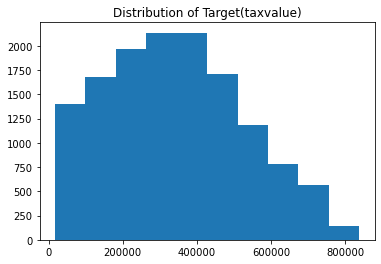

In [33]:
plt.hist(y_train)
plt.title('Distribution of Target(taxvalue)')
plt.show()

In [34]:

# 1. Predict taxvalue_pred_mean
taxvalue_pred_mean = y_train.taxvalue.mean()
y_train['taxvalue_pred_mean'] = taxvalue_pred_mean
y_validate['taxvalue_pred_mean'] = taxvalue_pred_mean


# 2. compute taxvalue_pred_median
taxvalue_pred_median = y_train.taxvalue.median()
y_train['taxvalue_pred_median'] = taxvalue_pred_median
y_validate['taxvalue_pred_median'] = taxvalue_pred_median


# 3. RMSE of taxvalue_pred_mean
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_mean) ** (1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of taxvalue_pred_median
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_median) ** .5
print("\nRMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  183280.54 
Validate/Out-of-Sample:  184140.0

RMSE using Median
Train/In-Sample:  183608.5 
Validate/Out-of-Sample:  184669.37


In [35]:
from sklearn.metrics import explained_variance_score

In [36]:

def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [37]:
metric_df = pd.DataFrame()
metric_df = make_metric_df(y_train.taxvalue,
                           y_train.taxvalue_pred_median,
                           'median_baseline',
                          metric_df)

In [50]:
metric_df = make_metric_df(y_train.taxvalue,
                           y_train.taxvalue_pred_mean,
                           'mean_baseline',
                          metric_df)

In [55]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000


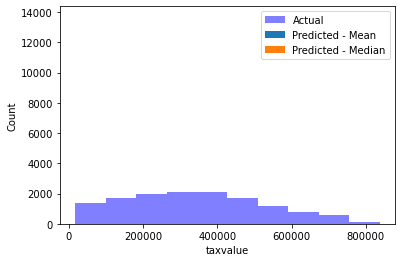

In [46]:

# plot to visualize actual vs predicted. 
plt.hist(y_train.taxvalue, color='blue', alpha=.5, label="Actual")
plt.hist(y_train.taxvalue_pred_mean, label="Predicted - Mean")
plt.hist(y_train.taxvalue_pred_median, label="Predicted - Median")
plt.xlabel("taxvalue")
plt.ylabel("Count")
plt.legend()
plt.show()

In [48]:
def linear_regression():

    lm = LinearRegression(normalize=True)

    lm.fit(X_train, y_train.taxvalue)

    y_train['taxvalue_pred_lm'] = lm.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lm) ** (1/2)

    # predict validate
    y_validate['taxvalue_pred_lm'] = lm.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lm) ** (1/2)

    return print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
                  "\nValidation/Out-of-Sample: ", rmse_validate)

In [49]:
linear_regression()

RMSE for OLS using LinearRegression
Training/In-Sample:  174317.49944991924 
Validation/Out-of-Sample:  174258.34726592238


In [53]:
metric_df = make_metric_df(y_validate.taxvalue,
                           y_validate.taxvalue_pred_lm,
                           'OLS Regressor',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487


In [56]:
def lassolars(a):
    # given a for alpha
    
    # create the model object
    lars = LassoLars(alpha=a)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series!
    lars.fit(X_train, y_train.taxvalue)

    # predict train
    y_train['taxvalue_pred_lars'] = lars.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lars) ** (1/2)

    # predict validate
    y_validate['taxvalue_pred_lars'] = lars.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lars) ** (1/2)

    return print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [57]:
lassolars(1)

RMSE for Lasso + Lars
Training/In-Sample:  174317.69682183256 
Validation/Out-of-Sample:  174260.48803471963


In [58]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lars,
               'lasso_alpha_1',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466


In [59]:
lassolars(2)

RMSE for Lasso + Lars
Training/In-Sample:  174318.28893623152 
Validation/Out-of-Sample:  174263.0212195972


In [60]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lars,
               'lasso_alpha_2',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440


In [74]:
def tweedie_regressor(p, a):
    
    # create the model object
    glm = TweedieRegressor(power=p, alpha=a)
    

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm.fit(X_train, y_train.taxvalue)

    # predict train
    y_train['taxvalue_pred_glm'] = glm.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_glm) ** (1/2)

    # predict validate
    y_validate['taxvalue_pred_glm'] = glm.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_glm) ** (1/2)

    return print(f"RMSE for GLM using Tweedie, power={p} & alpha={a}\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [69]:
tweedie_regressor(1, 0)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  183280.53956979554 
Validation/Out-of-Sample:  184139.99682273561


In [65]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_glm,
               'TweedieRegressor(p=1, a=0)',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440
6,"TweedieRegressor(p=1, a=0)",184139.996823,0.000000


In [70]:
tweedie_regressor(2,0)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  183280.53956979554 
Validation/Out-of-Sample:  184139.99682273561


In [67]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_glm,
               'TweedieRegressor(p=2, a=0)',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440
6,"TweedieRegressor(p=1, a=0)",184139.996823,0.000000
7,"TweedieRegressor(p=2, a=0)",184139.996823,0.000000


In [71]:
tweedie_regressor(1,1)

RMSE for GLM using Tweedie, power=1 & alpha=1
Training/In-Sample:  183280.53956979554 
Validation/Out-of-Sample:  184139.99682273561


In [72]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_glm,
               'TweedieRegressor(p=1, a=1)',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440
6,"TweedieRegressor(p=1, a=0)",184139.996823,0.000000
7,"TweedieRegressor(p=2, a=0)",184139.996823,0.000000
8,"TweedieRegressor(p=1, a=1)",184139.996823,0.000000


In [75]:
tweedie_regressor(2,1)

RMSE for GLM using Tweedie, power=2 & alpha=1
Training/In-Sample:  183280.53956979554 
Validation/Out-of-Sample:  184139.99682273561


In [76]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_glm,
               'TweedieRegressor(p=2, a=1)',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440
6,"TweedieRegressor(p=1, a=0)",184139.996823,0.000000
7,"TweedieRegressor(p=2, a=0)",184139.996823,0.000000
8,"TweedieRegressor(p=1, a=1)",184139.996823,0.000000
9,"TweedieRegressor(p=2, a=1)",184139.996823,0.000000


In [78]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)

In [79]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvalue)

# predict train
y_train['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lm2)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  173511.78370171433 
Validation/Out-of-Sample:  173763.3774131582


In [80]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lm2,
               'Polynomiald2',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440
6,"TweedieRegressor(p=1, a=0)",184139.996823,0.000000
7,"TweedieRegressor(p=2, a=0)",184139.996823,0.000000
8,"TweedieRegressor(p=1, a=1)",184139.996823,0.000000
9,"TweedieRegressor(p=2, a=1)",184139.996823,0.000000


In [81]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)

In [82]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.taxvalue)

# predict train
y_train['taxvalue_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lm3)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  173187.98742495655 
Validation/Out-of-Sample:  173325.12334838597


In [83]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lm3,
               'Polynomiald3',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440
6,"TweedieRegressor(p=1, a=0)",184139.996823,0.000000
7,"TweedieRegressor(p=2, a=0)",184139.996823,0.000000
8,"TweedieRegressor(p=1, a=1)",184139.996823,0.000000
9,"TweedieRegressor(p=2, a=1)",184139.996823,0.000000


In [84]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=4)

# fit and transform X_train_scaled
X_train_degree4 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree4 = pf.transform(X_validate)

In [86]:
# create the model object
lm4 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm4.fit(X_train_degree4, y_train.taxvalue)

# predict train
y_train['taxvalue_pred_lm4'] = lm4.predict(X_train_degree4)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lm4)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm4'] = lm4.predict(X_validate_degree4)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lm4)**(1/2)

print("RMSE for Polynomial Model, degrees=4\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=4
Training/In-Sample:  171925.34900748843 
Validation/Out-of-Sample:  172322.95757125653


In [87]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lm4,
               'Polynomiald4',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,183608.500703,0.000000
1,mean_baseline,183280.539570,0.000000
2,OLS Regressor,174258.347266,0.104487
3,validate_mean_baseline,184139.996823,0.000000
4,lasso_alpha_1,174260.488035,0.104466
5,lasso_alpha_2,174263.021220,0.104440
6,"TweedieRegressor(p=1, a=0)",184139.996823,0.000000
7,"TweedieRegressor(p=2, a=0)",184139.996823,0.000000
8,"TweedieRegressor(p=1, a=1)",184139.996823,0.000000
9,"TweedieRegressor(p=2, a=1)",184139.996823,0.000000


In [88]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=10)

# fit and transform X_train_scaled
X_train_degree10 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree10 = pf.transform(X_validate)

In [90]:
# create the model object
lm10 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm10.fit(X_train_degree10, y_train.taxvalue)

# predict train
y_train['taxvalue_pred_lm10'] = lm10.predict(X_train_degree10)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lm10)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm10'] = lm10.predict(X_validate_degree10)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lm10)**(1/2)

print("RMSE for Polynomial Model, degrees=10\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=10
Training/In-Sample:  170715.51772862548 
Validation/Out-of-Sample:  23134926.12107603


In [92]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lm10,
               'Polynomiald10',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,1.836085e+05,0.000000
1,mean_baseline,1.832805e+05,0.000000
2,OLS Regressor,1.742583e+05,0.104487
3,validate_mean_baseline,1.841400e+05,0.000000
4,lasso_alpha_1,1.742605e+05,0.104466
5,lasso_alpha_2,1.742630e+05,0.104440
6,"TweedieRegressor(p=1, a=0)",1.841400e+05,0.000000
7,"TweedieRegressor(p=2, a=0)",1.841400e+05,0.000000
8,"TweedieRegressor(p=1, a=1)",1.841400e+05,0.000000
9,"TweedieRegressor(p=2, a=1)",1.841400e+05,0.000000


You will need to figure out which field gives you the annual tax amount for the property in order to calculate the tax rate. Using the property's assessed value (taxvaluedollarcnt) and the amount they pay each year (<field name>) to compute tax rate.

In [93]:
df.head()

,yearbuilt,taxamount,fips,area,bed,bath,taxvalue,tdate_month,tdate_day,tdate_week,county
578,1974.0,3490.16,6059.0,1125.0,3.0,2.0,289445.0,8,4,31,Orange
950,1923.0,2627.48,6037.0,1316.0,3.0,2.0,205123.0,7,21,29,Los Angeles
1163,1970.0,2319.90,6037.0,1458.0,3.0,2.0,136104.0,6,23,25,Los Angeles
2494,1955.0,1399.27,6037.0,1491.0,3.0,2.0,107110.0,8,23,34,Los Angeles
3051,1949.0,7673.19,6037.0,1650.0,3.0,2.0,614000.0,6,1,22,Los Angeles


In [95]:
df["taxrate"] = df.taxamount / df.taxvalue

In [99]:
df.taxrate.describe()

count    24465.000000
mean         0.012961
std          0.003215
min          0.000787
25%          0.011592
50%          0.012272
75%          0.013411
max          0.142742
Name: taxrate, dtype: float64

In [100]:
df.groupby('county').taxrate.mean()

county
Los Angeles    0.013680
Orange         0.012025
Ventura        0.011686
Name: taxrate, dtype: float64

In [101]:
df.groupby('county').taxrate.median()

county
Los Angeles    0.012585
Orange         0.011636
Ventura        0.011293
Name: taxrate, dtype: float64

In [104]:
df.groupby('county').taxrate.describe()

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
Los Angeles,14349.0,0.013680,0.003479,0.000857,0.012142,0.012585,0.014037,0.142742
Orange,7643.0,0.012025,0.002493,0.001449,0.010450,0.011636,0.012604,0.107350
Ventura,2473.0,0.011686,0.002351,0.000787,0.010701,0.011293,0.011878,0.062454


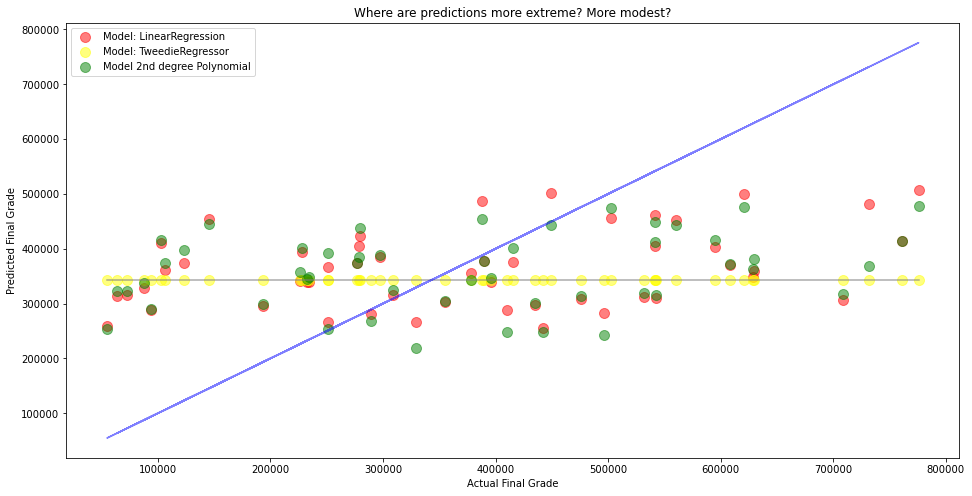

In [111]:
# y_validate.head()
y_validate_sample = y_validate.sample(n=50)


plt.figure(figsize=(16,8))
plt.plot(y_validate_sample.taxvalue, y_validate_sample.taxvalue_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate_sample.taxvalue, y_validate_sample.taxvalue, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate_sample.taxvalue, y_validate_sample.taxvalue_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate_sample.taxvalue, y_validate_sample.taxvalue_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate_sample.taxvalue, y_validate_sample.taxvalue_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


,taxvalue,taxvalue_pred_mean,taxvalue_pred_median,taxvalue_pred_lm,taxvalue_pred_lars,taxvalue_pred_glm,taxvalue_pred_lm2,taxvalue_pred_lm3,taxvalue_pred_lm4,taxvalue_pred_lm10
43129,310029.0,343838.291022,332869.0,419395.680664,418291.174594,343838.291022,407419.792489,404300.304850,400005.277425,432741.478516
47462,654241.0,343838.291022,332869.0,320832.090494,321008.391939,343838.291022,330188.050151,326269.575578,320699.685142,312380.041016
32794,154108.0,343838.291022,332869.0,285580.292382,285652.585772,343838.291022,276299.849908,268925.480431,263638.504853,265140.308594
51079,247358.0,343838.291022,332869.0,396725.529026,396295.207454,343838.291022,403987.965227,410049.432708,395114.745353,398608.916016
40814,329955.0,343838.291022,332869.0,298452.058303,298411.154792,343838.291022,297348.276464,294152.984472,288157.860304,290585.451172


In [113]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

In [117]:
kbest = SelectKBest(f_regression, k=1)
kbest.fit(X_train_scaled, y_train.taxvalue)

X_train.columns[kbest.get_support()]

Index(['area'], dtype='object')

In [118]:
pd.Series(X_train.columns, index=kbest.scores_).sort_index(0)

56.669752       bed
667.402604     bath
1110.378706    area
dtype: object

In [121]:
df.head()

,yearbuilt,taxamount,fips,area,bed,bath,taxvalue,tdate_month,tdate_day,tdate_week,county,taxrate
578,1974.0,3490.16,6059.0,1125.0,3.0,2.0,289445.0,8,4,31,Orange,0.012058
950,1923.0,2627.48,6037.0,1316.0,3.0,2.0,205123.0,7,21,29,Los Angeles,0.012809
1163,1970.0,2319.90,6037.0,1458.0,3.0,2.0,136104.0,6,23,25,Los Angeles,0.017045
2494,1955.0,1399.27,6037.0,1491.0,3.0,2.0,107110.0,8,23,34,Los Angeles,0.013064
3051,1949.0,7673.19,6037.0,1650.0,3.0,2.0,614000.0,6,1,22,Los Angeles,0.012497


In [127]:

rfe = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe.fit(df[['fips', 'area', 'bed', 'bath', 'tdate_month', 'tdate_day', 'tdate_week']], df.taxvalue)
rfe.get_support()

array([False, False, False,  True,  True, False,  True])

In [136]:
col_list = ['fips', 'area', 'bed', 'bath', 'tdate_month', 'tdate_day', 'tdate_week']

In [139]:
df[col_list].columns[rfe.get_support()]

Index(['bath', 'tdate_month', 'tdate_week'], dtype='object')

In [140]:
pd.Series(df[col_list].columns, index=rfe.ranking_).sort_index(0)

1           bath
1    tdate_month
1     tdate_week
2      tdate_day
3            bed
4           fips
5           area
dtype: object